# 1、导入需要的各类包，设置pandas显示长度，中文画图环境

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import scorecardpy as sc
import sys
sys.path.append("D:\\github\\xiao_tools")
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 5000)
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']
sc.__version__

'0.1.9.2'

In [2]:
import xiao_tools

# 2、读取数据，并把列名修改为中文，便于后面分析数据。

In [3]:
import pandas as pd
#读入字段解释数据并处理成以指标为index的DataFrame
#dd=pd.read_excel('illustration.XLSX',skiprows=[0]).fillna(method='ffill').drop([0])
# dd=pd.read_excel('illustration.XLSX').fillna(method='ffill').drop([0])
dd=pd.read_excel('..\\data\\illustration.XLSX').fillna(method='ffill').drop([0])
dicts=pd.DataFrame(dd.reset_index(drop=True).values,columns=['illus2','vars','illus1','logical_illus'])
dicts.set_index('vars',drop=True)
dicts=dicts[['vars','illus1','illus2','logical_illus']].set_index('vars',drop=True)
# dicts.reset_index(inplace=True)

# dat1=pd.read_csv('train_data.csv')
dat1=pd.read_csv('..\\data\\train_data.csv')   #上级目录data文件夹中的文件
col_0=dat1.columns.to_list()
col_1=[dicts.loc[x].illus1 for x in col_0]
dat=pd.DataFrame(dat1.values,columns=col_1)    #dat 中数据类型已经发生改变，可能原因为dat1.values
dat.drop(columns=['user_id'],inplace=True)

In [ ]:
dat.info()

# 3、 利用scorecardpy 对变量进行初筛：
## iv_limit=0.02, missing_limit=0.95, identical_limit=0.95，ar_rm=None, var_kp=None, return_rm_reason=False, positive='bad|1'

In [ ]:
#dt_s = sc.var_filter(dat,y="是否逾期")          #----------全部字段过滤
#dt_s = sc.var_filter(dat, y="y",x=xcol)         #----------return a DataFrame only filters out from [x]
dt_s = sc.var_filter(dat, y="是否逾期",
                     return_rm_reason=True)      #---return a dict(2 DataFrame) with keys:['dt','rm']

dt_s1=dt_s["dt"]                                 #--过滤后保留的字段
dt_s2=dt_s["rm"]                                 #--被过滤的字段：rm_reason不是nan的，保留字段：rm_reason 为nan

### 查看筛选结果，按照iv (info_value) 排序，检查特别高的iv字段
#### 需要注意的这儿的iv计算方法（在var_filter中）：是直接按照每个字段的unique分组计算求和的，所以对于连续型变量，iv值偏大。通过测试发现，按照woebin之后计算的iv为合理的iv值。

In [ ]:
dt_s2[dt_s2.info_value.sort_values(ascending=False) > 0.5].sort_values(by='info_value',ascending=False).head()

[INFO] creating woe binning ...


{'近6个月金融类消费笔数均值/标准差': <Figure size 432x288 with 2 Axes>}

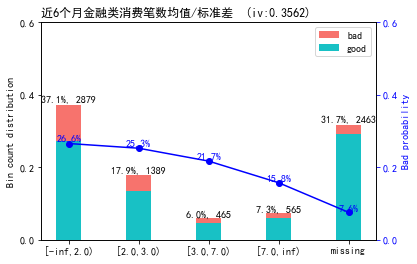

In [4]:
bins=sc.woebin(dat.astype(float),y='是否逾期',x=['近6个月金融类消费笔数均值/标准差'])
bins['近6个月金融类消费笔数均值/标准差']=bins['近6个月金融类消费笔数均值/标准差'].sort_values(by='breaks')
sc.woebin_plot(bins)

{'近6个月金融类消费笔数均值/标准差': <Figure size 1296x864 with 2 Axes>}

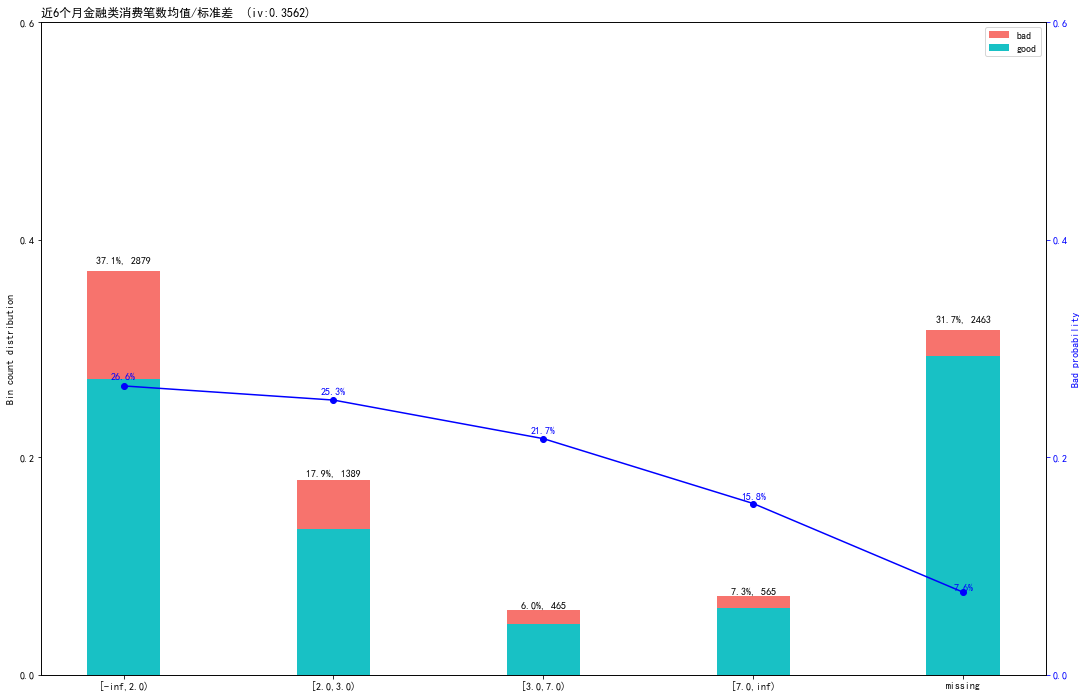

In [13]:
xiao_tools.woebin_plot(bins,xsize=18,ysize=12)

In [ ]:
def gb_distr(binx):
    binx['good_distr'] = binx['good']/sum(binx['count'])
    binx['bad_distr'] = binx['bad']/sum(binx['count'])
    return binx

In [ ]:
binss=gb_distr(bins['近6个月金融类消费笔数均值/标准差'])

In [ ]:
binss=bins['近6个月金融类消费笔数均值/标准差']

plot_bin(binss,'xx', show_iv=True)

In [ ]:
#这儿也可以单独计算变量的iv值
# iv0=sc.iv(dat.astype(float),y='是否逾期',order=True)
# iv0.head()

In [ ]:
#此部分为了测试，将字段按照1/10比例分段后，计算iv值，结果正常。
# #print(bins['x_003'])
# #print(pd.cut(dat['近6个月交易金额均值/标准差'],[float('-inf'),0,float('inf')],right=False).sort_values())
# ppcut=pd.DataFrame()
# pcut=pd.qcut(dat['近6个月交易金额均值/标准差'], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],retbins=False, precision=3, duplicates='drop')
# ppcut['inter']=pcut
# ppcut['right']=[x.right if isinstance(x,pd._libs.interval.Interval) else x for x in pcut]
# ppcut.sort_values('right').right.unique()
# ppcut.sort_values('right')
# ppcut
# sc.iv(pd.DataFrame({'x':pcut,'y':dat['是否逾期']}),'y')

In [ ]:
#查看初步筛选结果
bins=sc.woebin(dt_s1.astype(float),y="是否逾期")
sc.woebin_plot(bins)

In [ ]:
#基于woebin后的IV > 0.02 进一步筛选
#np.sort([bins[x].total_iv.unique()[0] for x in bins.keys()])
feature_iv=pd.DataFrame([[k,v.total_iv[0]] for k,v in bins.items()],columns=['feature','iv']).sort_values(by='iv',ascending=False)
# feature_iv['illus']=[dicts.loc[x]['illus1'] for x in feature_iv['feature']]
feature_iv_gt_02=feature_iv[feature_iv.iv > 0.02].feature.to_list()
len(feature_iv_gt_02)

# 4、相关性分析及变量筛选

In [ ]:
# 按照特征iv值由大到小重新生成DataFrame 
dt=pd.DataFrame()
for x in feature_iv_gt_02:
    dt[x]=dt_s1[x].fillna(0)

#删除相关性 > 0.7的字段对中IV值小的字段
import seaborn as sns
xx1=dt.corr().abs()
plt.subplots(figsize=(18,12))
upper1 = xx1.where(np.triu(np.ones(xx1.shape), k=1).astype(np.bool))
to_drop = [column for column in xx1.columns if any(upper1[column] > 0.7)]
#print(to_drop)
print('%d columns to remove.' % (len(to_drop)))
dt_drop_cor=dt.drop(to_drop,axis=1)
sns.heatmap(dt_drop_cor.corr())
feature_drop_cor=dt_drop_cor.columns.to_list()
print("%s features left after filter with correlation" %len(feature_drop_cor))

# 5、多重共线性筛选

In [ ]:
#定义vif选择函数，保留thres < 10.0的字段
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(x, thres=10.0):
    X_m = np.matrix(x)
    VIF_list = [variance_inflation_factor(X_m, i) for i in range(X_m.shape[1])]
    maxvif=pd.DataFrame(VIF_list,index=x.columns,columns=["vif"])
    col_save=list(maxvif[maxvif.vif<=float(thres)].index)
    col_delete=list(maxvif[maxvif.vif>float(thres)].index)
    #print(maxvif)
    #print('delete Variables:', col_delete)
    return x[col_save]

#基于vif进行筛选
ddx=pd.DataFrame()
for x in feature_drop_cor:
    #ddx[x]=dat[x].fillna(dat[x].min())
    ddx[x]=dt_s1[x].fillna(0)    
ddy=vif(ddx,thres=5)
feature_after_vif=ddy.columns.to_list()
print("Delete Variables:%s" %list(set(ddx.columns)-set(ddy.columns)))
feature_after_vif.append('是否逾期')

In [ ]:
#查看最后筛选字段woe分段情况
bins=sc.woebin(dt_s1[feature_after_vif].astype(float),y="是否逾期")
sc.woebin_plot(bins)

In [ ]:
#print(bins['x_003'])
#print(pd.cut(dt_s['x_003'],[float('-inf'),0,float('inf')],right=False).sort_values())
#.astype(str).value_counts()

In [ ]:
# binning adjustment
# # adjust breaks interactively
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
# breaks_adj = {
#     'x_003': [26, 35],
#     'other.debtors.or.guarantors': ["none", "co-applicant%,%guarantor"]
# }
# bins_adj = sc.woebin(dt_s, y="y", x="x_003", breaks_list={"x_003":[0.5]})
# sc.woebin_plot(bins_adj)
# bins=sc.woebin(dt_s, y="y", x="x_003")
# sc.woebin_plot(bins_adj)

# 6、数据拟合 WOE编码+逻辑回归

In [ ]:
#切分数据集
train, test = sc.split_df(dt_s1[feature_after_vif], '是否逾期').values()
#获取bins、woe
bins=sc.woebin(train.astype(float),y='是否逾期')
print("Dimension of train_data:",train.shape)

# converting train and test into woe values
train_woe = sc.woebin_ply(train.astype(float), bins)
test_woe = sc.woebin_ply(test.astype(float), bins)

y_train = train_woe.loc[:,'是否逾期']
X_train = train_woe.loc[:,train_woe.columns != '是否逾期']
y_test = test_woe.loc[:,'是否逾期']
X_test = test_woe.loc[:,train_woe.columns != '是否逾期']

# logistic regression ------base on Sklearn
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
print("coef of LR_fit:",lr.coef_)

# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# 7、基于statsmodels的逻辑回归、可根据变量显著性对变量进行选择

In [ ]:
# 初步回归，检查系数和显著性
import statsmodels.api as sm
from scipy import stats
X = X_train
y = y_train
X2 = sm.add_constant(X)
sml=sm.Logit(y,X2)
sml1=sml.fit(disp=0)
sml1.summary()

# 7.1、采用逐步回归的方式选择入模变量

In [ ]:
#逐步回归函数
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.02,
                       threshold_out = 0.02,
                       verbose = True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
 
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
#             model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit() #----------线性回归
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit(disp=0)#--------逻辑回归
            new_pval[new_column] = model.pvalues[new_column]
        #print('new_pval',new_pval)
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            #best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            #print('................',included)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
 
        # backward step
        #model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit() #----------线性回归
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)#--------逻辑回归
        #print(included)
        pvalues=model.pvalues
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
# 通过迭代的方式，抛弃符号不正确的变量+再次stepwise选择变量，直到全部变量符号一致。
i=0
drop_col=[]
while True:
    result=stepwise_selection(X_train.drop(columns=drop_col),y_train,threshold_in=0.02,threshold_out = 0.02)
    X = X_train[result]
    y = y_train
    X2 = sm.add_constant(X)
    sml=sm.Logit(y,X2)
    sml1=sml.fit(disp=0)
    fit_result=pd.DataFrame()
    fit_result['coef']=sml1.params
    fit_result['pvalue']=sml1.pvalues
    drop_col0=list(fit_result[fit_result.coef < 0].index[1:])
    drop_col=drop_col+drop_col0
    print(drop_col)
    if len(drop_col0)==0:
        break
    else:
        i+=1
        print("this is %s-th" %i)

print("-------------------------------------------------------------------------------------------")
print("------------------最后入模变量-------------------------------------------------------------")
print(result)
print("-------------------------------------------------------------------------------------------")


# 8、最终模型

In [ ]:
X = X_train[result]
y = y_train
X2 = sm.add_constant(X)
sml=sm.Logit(y,X2)
sml1=sml.fit(disp=0)
sml1.summary()

## 8.1、模型评价指标展示

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train[result], y_train)
train_pred = lr.predict_proba(X_train[result])[:,1]
test_pred = lr.predict_proba(X_test[result])[:,1]
# train_perf = sc.perf_eva(y_train, train_pred, title = "train")
# test_perf = sc.perf_eva(y_test, test_pred, title = "test")
test_perf = sc.perf_eva(y_train, train_pred, plot_type = ["ks","lift","roc","pr"],title = "test")
test_perf = sc.perf_eva(y_test, test_pred, plot_type = ["ks","lift","roc","pr"],title = "test")

In [ ]:
#展示入模变量、IV、cof、P_val(z)
pd.DataFrame([(x,
               feature_iv.set_index('feature').iv.loc[x.replace('_woe','')],
               sml1.params.loc[x],
               sml1.pvalues.loc[x]) for x in result],
               columns=['vars','iv','cof','P_val'])

In [ ]:
# score ------
card = sc.scorecard(bins, lr, X_train[result].columns)
# credit score
train_score = sc.scorecard_ply(train.astype(float), card, print_step=0)
test_score = sc.scorecard_ply(test.astype(float), card, print_step=0)

In [ ]:
# psi
psi=sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)